# 환경 세팅

## 한글폰트 설치 (런타임 재시작 필요)

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (39.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120901 files and direc

## lightgbm 버전 다운그레이드 (런타임 재시작 필요)
- lightgbm 3.3.2 버전

In [2]:
!pip install lightgbm==3.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.5 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.0.0
    Uninstalling lightgbm-4.0.0:
      Successfully uninstalled lightgbm-4.0.0


## XGBOOST 설치

In [3]:
!pip install xgboost

## Graphviz 설치

In [29]:
!pip install graphviz

## 런타임 재시작 후 설치 확인

In [1]:
import lightgbm
lightgbm.__version__

'3.3.2'

In [2]:
import xgboost
xgboost.__version__

'1.7.6'

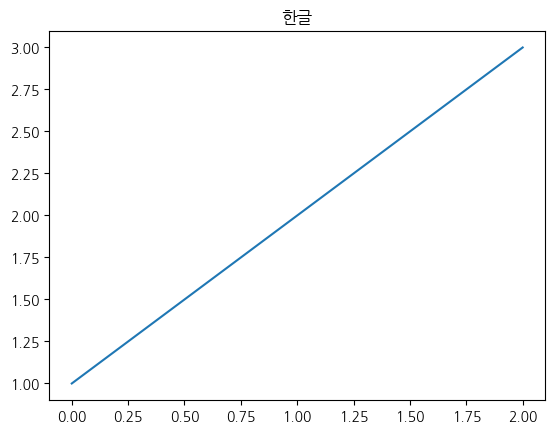

In [3]:
import matplotlib.pyplot as plt
plt.rc("font", family="NanumGothic") # 라이브러리 불러오기와 함께 한번만 실행

plt.plot([1, 2, 3])
plt.title("한글")
plt.show()

## 구글 드라이브 연동

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# 데이터 불러오기

In [5]:
import pandas as pd

DATA_PATH = '/content/drive/MyDrive/세미프로젝트/data/' # 본인 경로 사용
data = pd.read_csv(DATA_PATH + '머신러닝.csv') # 본인 파일 이름 사용
data.head()

,요일,연도,역명,방향,시간대,혼잡도
0,평일,2017,서울역,상선,05시~06시,8.7
1,평일,2017,시청,상선,05시~06시,7.8
2,평일,2017,종각,상선,05시~06시,6.3
3,평일,2017,종로3가,상선,05시~06시,6.3
4,평일,2017,종로5가,상선,05시~06시,5.8


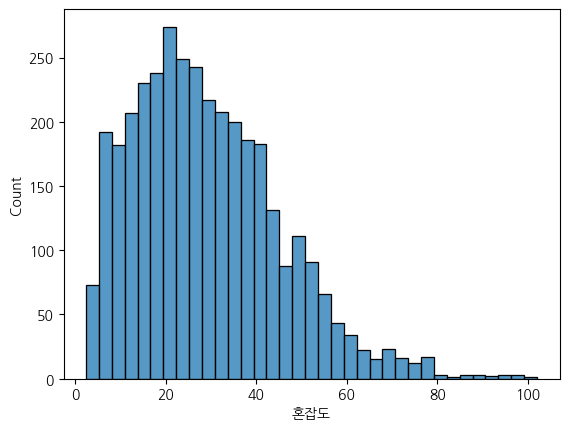

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.histplot(data=data, x='혼잡도')
plt.show()

# 종속변수 분포 정규화 (필요시)

In [7]:
# 추후 필요시 추가예정

# 하이퍼 파라미터 튜닝

## 랜덤서치 (대략적인 범위나 경향 파악하기)

### LGBMRegressor

In [12]:
import pandas as pd
import lightgbm as lgb
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 데이터를 독립변수(X)와 종속변수(y)로 나눕니다.
X = data[['시간대', '요일', '방향', '연도', '역명']]
y = data['혼잡도']

# 범주형 열에 OneHot 인코딩을 적용
categorical_features = ['시간대', '요일', '방향', '역명']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')  # 나머지 변수를 유지

# 데이터를 학습, 테스트 데이터로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# LightGBM 모델 정의
lgb_reg = lgb.LGBMRegressor(random_state=42)

# 파이프라인 정의
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # ColumnTransformer를 적용
    ('LGB_reg', lgb_reg)  # LGBMRegressor 모델 사용
])

# 튜닝할 하이퍼파라미터 분포 정의
param_dist = {
    'LGB_reg__learning_rate': [0.01, 0.05, 0.1],
    'LGB_reg__n_estimators': [100, 500, 1000],
    'LGB_reg__max_depth': [6, 4, 8],
    'LGB_reg__colsample_bytree': [1.0, 0.9, 0.8, 0.7],
    'LGB_reg__subsample': [1.0, 0.9, 0.8, 0.7],
    'LGB_reg__min_child_samples': [20, 50, 100],
    'LGB_reg__reg_alpha': [0, 0.01, 0.1],
    'LGB_reg__reg_lambda': [0, 0.01, 0.1]
}

# RandomizedSearchCV 객체 생성
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=500, cv=10,
                                   scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, random_state=42,
                                   return_train_score=True, refit=True)

# RandomizedSearchCV를 사용하여 최적 하이퍼파라미터 찾기
random_search.fit(X_train, y_train)

# 에포크와 결과 출력 (params 출력은 길어서 뺐음)
results = random_search.cv_results_
for epoch, (mean_score, params) in enumerate(zip(results["mean_test_score"], results["params"])):
    if epoch % 50 == 0:
        print(f"에포크 {epoch + 1}, 평균 MSE: {mean_score:.4f}")

# 최적 하이퍼파라미터 출력
print("최적 하이퍼파라미터:", random_search.best_params_)

# 최적 모델 저장
best_model = random_search.best_estimator_
joblib.dump(best_model, 'best_lgb_reg_randomized.pkl')

# 테스트 데이터를 사용하여 모델의 성능을 평가합니다.
y_test_pred = best_model.predict(X_test)

# MAE, RMSE, R2 Score 계산
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)

# 결과를 출력합니다.
print("\nTest 성능 지표:")
print("Mean Absolute Error (MAE):", mae_test)
print("Root Mean Squared Error (RMSE):", rmse_test)
print("R-squared (R2):", r2_test)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
에포크 1, 평균 MSE: -53.5003
에포크 51, 평균 MSE: -22.6355
에포크 101, 평균 MSE: -18.9774
에포크 151, 평균 MSE: -32.7433
에포크 201, 평균 MSE: -16.6644
에포크 251, 평균 MSE: -64.0694
에포크 301, 평균 MSE: -59.8279
에포크 351, 평균 MSE: -32.7381
에포크 401, 평균 MSE: -38.9693
에포크 451, 평균 MSE: -59.6044
최적 하이퍼파라미터: {'LGB_reg__subsample': 0.9, 'LGB_reg__reg_lambda': 0.1, 'LGB_reg__reg_alpha': 0.01, 'LGB_reg__n_estimators': 1000, 'LGB_reg__min_child_samples': 20, 'LGB_reg__max_depth': 8, 'LGB_reg__learning_rate': 0.1, 'LGB_reg__colsample_bytree': 0.9}

Test 성능 지표:
Mean Absolute Error (MAE): 1.9912171076318164
Root Mean Squared Error (RMSE): 2.8970436387503278
R-squared (R2): 0.9704385847421497


### XGBRegressor

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# 데이터를 독립변수(X)와 종속변수(y)로 나눕니다.
X = data[['시간대', '요일', '방향', '연도', '역명']]
y = data['혼잡도']

# 범주형 열에 OneHot 인코딩을 적용
categorical_features = ['시간대', '요일', '방향', '역명']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')  # 나머지 변수를 유지

# 데이터를 학습, 검증, 테스트 데이터로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# XGBoost 모델 정의
xgb_reg = XGBRegressor(random_state=42)

# 파이프라인 정의
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # ColumnTransformer를 적용
    ('XGB_reg', xgb_reg)  # XGBRegressor 모델 사용
])

# 튜닝할 하이퍼파라미터 분포 정의 (RandomizedSearchCV에서는 분포 사용)
param_dist = {
    'XGB_reg__learning_rate': [0.01, 0.05, 0.1],
    'XGB_reg__n_estimators': [100, 500, 1000],
    'XGB_reg__max_depth': [3, 5, 7],
    'XGB_reg__min_child_weight': [1, 5, 10],
    'XGB_reg__colsample_bytree': [1.0, 0.9, 0.8, 0.7],
    'XGB_reg__subsample': [1.0, 0.9, 0.8, 0.7],
    'XGB_reg__gamma': [0, 0.1, 0.2],
    'XGB_reg__alpha': [0, 0.01, 0.1],
    'XGB_reg__lambda': [0, 0.01, 0.1]
}

# RandomizedSearchCV 객체 생성
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=100, cv=5,
                                   scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, random_state=42,
                                   return_train_score=True, refit=True)

# RandomizedSearchCV를 사용하여 최적 하이퍼파라미터 찾기
random_search.fit(X_train, y_train)

# 에포크와 결과 출력 (params 출력은 길어서 뺐음)
results = random_search.cv_results_
for epoch, (mean_score, params) in enumerate(zip(results["mean_test_score"], results["params"])):
    if epoch % 10 == 0:
        print(f"에포크 {epoch + 1}, 평균 MSE: {mean_score:.4f}")

# 최적 하이퍼파라미터 출력
print("최적 하이퍼파라미터:", random_search.best_params_)

# 최적 모델 저장
best_model = random_search.best_estimator_
joblib.dump(best_model, 'best_xgb_reg_randomized.pkl')

# 테스트 데이터를 사용하여 모델의 성능을 평가합니다.
y_test_pred = best_model.predict(X_test)

# MAE, RMSE, R2 Score 계산
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)

# 결과를 출력합니다.
print("\nTest 성능 지표:")
print("Mean Absolute Error (MAE):", mae_test)
print("Root Mean Squared Error (RMSE):", rmse_test)
print("R-squared (R2):", r2_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
에포크 1, 평균 MSE: -46.0378
에포크 11, 평균 MSE: -26.2550
에포크 21, 평균 MSE: -9.7385
에포크 31, 평균 MSE: -31.5500
에포크 41, 평균 MSE: -12.5331
에포크 51, 평균 MSE: -10.4550
에포크 61, 평균 MSE: -19.8572
에포크 71, 평균 MSE: -18.9002
에포크 81, 평균 MSE: -8.3834
에포크 91, 평균 MSE: -13.8300
최적 하이퍼파라미터: {'XGB_reg__subsample': 0.7, 'XGB_reg__n_estimators': 1000, 'XGB_reg__min_child_weight': 5, 'XGB_reg__max_depth': 7, 'XGB_reg__learning_rate': 0.1, 'XGB_reg__lambda': 0.01, 'XGB_reg__gamma': 0.2, 'XGB_reg__colsample_bytree': 0.9, 'XGB_reg__alpha': 0.01}

Test 성능 지표:
Mean Absolute Error (MAE): 1.54336382661547
Root Mean Squared Error (RMSE): 2.2841725617627997
R-squared (R2): 0.9816230696811747


## 그리드 서치 (적정범위 다시 선정)

### LGBMRegressor

- param_grid
    + 'LGB_reg__learning_rate': [0.1]
    + 'LGB_reg__n_estimators': [1000]
    + 'LGB_reg__max_depth': [8, 9, 10]
    + 'LGB_reg__colsample_bytree': [1.9, 0.9, 0.8]
    + 'LGB_reg__subsample': [1.0, 0.9, 0.8]
    + 'LGB_reg__min_child_samples': [19, 20, 21]
    + 'LGB_reg__reg_alpha': [0.01]
    + 'LGB_reg__reg_lambda': [0.1]

In [41]:
import lightgbm as lgb
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 데이터를 독립변수(X)와 종속변수(y)로 나눕니다.
X = data[['시간대', '요일', '방향', '연도', '역명']]
y = data['혼잡도']

# 범주형 열에 OneHot 인코딩을 적용
categorical_features = ['시간대', '요일', '방향', '역명']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')  # 나머지 변수를 유지

# 데이터를 학습, 테스트 데이터로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# LightGBM 모델 정의
lgb_reg = lgb.LGBMRegressor(random_state=42)

# 파이프라인 정의
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # ColumnTransformer를 적용
    ('LGB_reg', lgb_reg)  # LGBMRegressor 모델 사용
])

# 튜닝할 하이퍼파라미터 그리드 정의
param_grid = {
    'LGB_reg__learning_rate': [0.1],
    'LGB_reg__n_estimators': [1000],
    'LGB_reg__max_depth': [8, 9, 10],
    'LGB_reg__colsample_bytree': [1.0, 0.9, 0.8],
    'LGB_reg__subsample': [1.0, 0.9, 0.8],
    'LGB_reg__min_child_samples': [19, 20, 21],
    'LGB_reg__reg_alpha': [0.01],
    'LGB_reg__reg_lambda': [0.1]
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error',
                            verbose=2, n_jobs=-1, return_train_score=True, refit=True)

# GridSearchCV를 사용하여 최적 하이퍼파라미터 찾기
grid_search.fit(X_train, y_train)

# 에포크와 결과 출력 (params 출력은 길어서 뺐음)
results = grid_search.cv_results_
for epoch, (mean_score, params) in enumerate(zip(results["mean_test_score"], results["params"])):
    if epoch % 10 == 0:
        print(f"에포크 {epoch + 1}, 평균 MSE: {mean_score:.4f}")

# 최적 하이퍼파라미터 출력
print("최적 하이퍼파라미터:", grid_search.best_params_)

# 최적 모델 저장
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'best_lgb_reg.pkl')

# 테스트 데이터를 사용하여 모델의 성능을 평가합니다.
y_test_pred = best_model.predict(X_test)

# MAE, RMSE, R2 Score 계산
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)

# 결과를 출력합니다.
print("\nTest 성능 지표:")
print("Mean Absolute Error (MAE):", mae_test)
print("Root Mean Squared Error (RMSE):", rmse_test)
print("R-squared (R2):", r2_test)

Fitting 10 folds for each of 81 candidates, totalling 810 fits
에포크 1, 평균 MSE: -8.7908
에포크 11, 평균 MSE: -8.1104
에포크 21, 평균 MSE: -7.4331
에포크 31, 평균 MSE: -8.7725
에포크 41, 평균 MSE: -8.0634
에포크 51, 평균 MSE: -7.2433
에포크 61, 평균 MSE: -9.0120
에포크 71, 평균 MSE: -8.1113
에포크 81, 평균 MSE: -7.5691
최적 하이퍼파라미터: {'LGB_reg__colsample_bytree': 0.9, 'LGB_reg__learning_rate': 0.1, 'LGB_reg__max_depth': 10, 'LGB_reg__min_child_samples': 20, 'LGB_reg__n_estimators': 1000, 'LGB_reg__reg_alpha': 0.01, 'LGB_reg__reg_lambda': 0.1, 'LGB_reg__subsample': 1.0}

Test 성능 지표:
Mean Absolute Error (MAE): 1.8183755802407537
Root Mean Squared Error (RMSE): 2.6574066220744452
R-squared (R2): 0.9751268279625191


<Figure size 2000x1000 with 0 Axes>

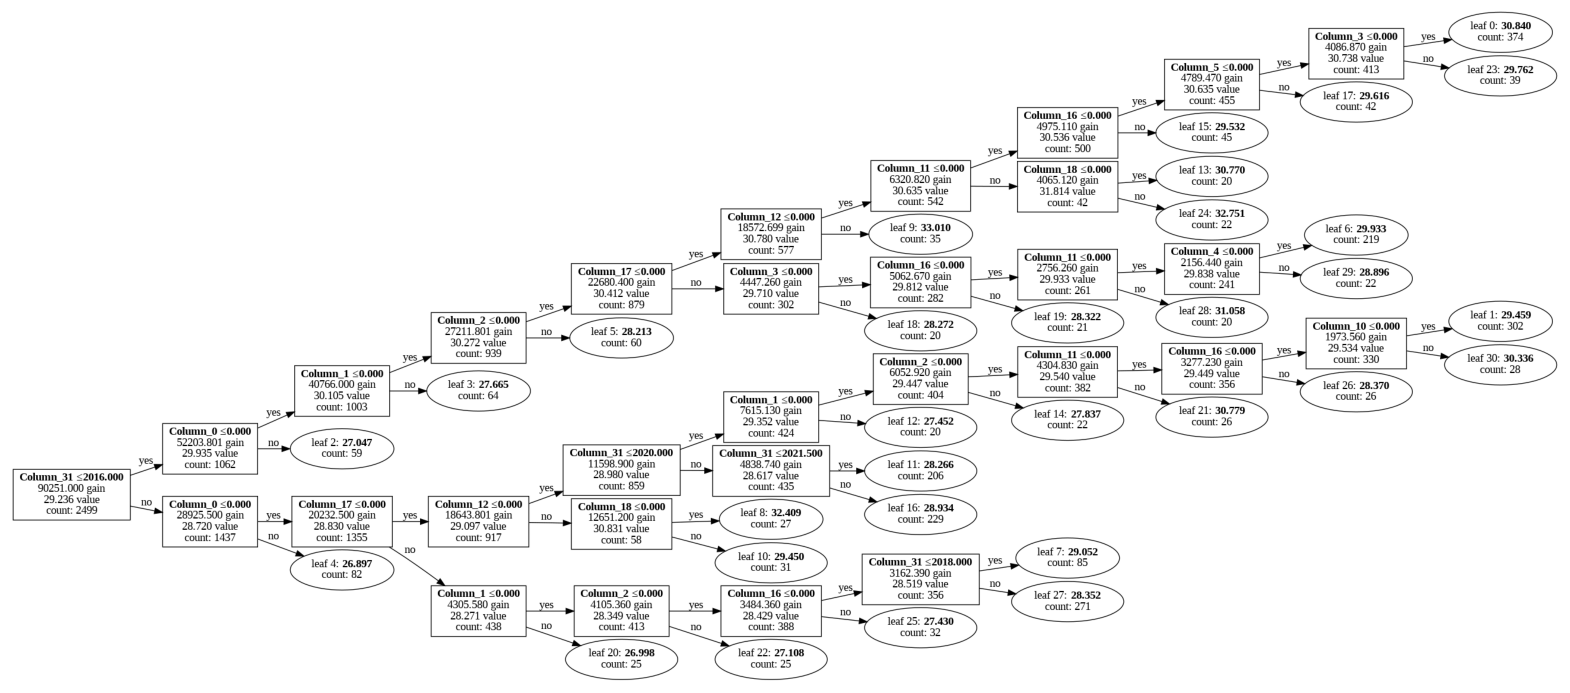

In [73]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import joblib
%matplotlib inline

# 저장된 모델 파일을 불러옵니다.
pipeline = joblib.load('best_lgb_reg.pkl')
model = pipeline.named_steps['LGB_reg']

# 특정 트리 번호를 선택하여 시각화
tree_number = 0  # 원하는 트리 번호 선택
plt.figure(figsize=(20, 10))
lgb.plot_tree(model, tree_index=tree_number, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
plt.show()

### XGBRegressor

- param_grid
    + 'XGB_reg__learning_rate': [0.1]
    + 'XGB_reg__n_estimators': [1000]
    + 'XGB_reg__max_depth': [8, 9, 10]
    + 'XGB_reg__min_child_weight': [4, 5, 6]
    + 'XGB_reg__colsample_bytree': [1.0, 0.9, 0.8]
    + 'XGB_reg__subsample': [0.8, 0.7, 0.6]
    + 'XGB_reg__gamma': [0.2]
    + 'XGB_reg__alpha': [0.01]
    + 'XGB_reg__lambda': [0.01]


In [47]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# 데이터를 독립변수(X)와 종속변수(y)로 나눕니다.
X = data[['시간대', '요일', '방향', '연도', '역명']]
y = data['혼잡도']

# 범주형 열에 OneHot 인코딩을 적용
categorical_features = ['시간대', '요일', '방향', '역명']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')  # 나머지 변수를 유지

# 데이터를 학습, 검증, 테스트 데이터로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# XGBoost 모델 정의
xgb_reg = XGBRegressor(random_state=42)

# 파이프라인 정의
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # ColumnTransformer를 적용
    ('XGB_reg', xgb_reg)  # XGBRegressor 모델 사용
])

# 튜닝할 하이퍼파라미터 그리드 정의
param_grid = {
    'XGB_reg__learning_rate': [0.1],
    'XGB_reg__n_estimators': [1000],
    'XGB_reg__max_depth': [8, 9, 10],
    'XGB_reg__min_child_weight': [4, 5, 6],
    'XGB_reg__colsample_bytree': [1.0, 0.9, 0.8],
    'XGB_reg__subsample': [0.8, 0.7, 0.6],
    'XGB_reg__gamma': [0.2],
    'XGB_reg__alpha': [0.01],
    'XGB_reg__lambda': [0.01]
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error',
                           verbose=2, n_jobs=-1, return_train_score=True, refit=True)

# GridSearchCV를 사용하여 최적 하이퍼파라미터 찾기
grid_search.fit(X_train, y_train)

# 에포크와 결과 출력 (params 출력은 길어서 뺐음)
results = grid_search.cv_results_
for epoch, (mean_score, params) in enumerate(zip(results["mean_test_score"], results["params"])):
    if epoch % 50 == 0:
        print(f"에포크 {epoch + 1}, 평균 MSE: {mean_score:.4f}")

# 최적 하이퍼파라미터 출력
print("최적 하이퍼파라미터:", grid_search.best_params_)

# 최적 모델 저장
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'best_xgb_reg.pkl')

# 테스트 데이터를 사용하여 모델의 성능을 평가합니다.
y_test_pred = best_model.predict(X_test)

# MAE, RMSE, R2 Score 계산
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)

# 결과를 출력합니다.
print("\nTest 성능 지표:")
print("Mean Absolute Error (MAE):", mae_test)
print("Root Mean Squared Error (RMSE):", rmse_test)
print("R-squared (R2):", r2_test)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
에포크 1, 평균 MSE: -10.6659
에포크 51, 평균 MSE: -11.1116
최적 하이퍼파라미터: {'XGB_reg__alpha': 0.01, 'XGB_reg__colsample_bytree': 0.9, 'XGB_reg__gamma': 0.2, 'XGB_reg__lambda': 0.01, 'XGB_reg__learning_rate': 0.1, 'XGB_reg__max_depth': 8, 'XGB_reg__min_child_weight': 4, 'XGB_reg__n_estimators': 1000, 'XGB_reg__subsample': 0.8}

Test 성능 지표:
Mean Absolute Error (MAE): 1.4495343202970274
Root Mean Squared Error (RMSE): 2.2928463860800283
R-squared (R2): 0.9814832370660695


In [74]:
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib
%matplotlib inline

# 저장된 모델 파일을 불러옵니다.
pipeline = joblib.load('best_xgb_reg.pkl')
model = pipeline.named_steps['XGB_reg']

# 특정 트리 번호를 선택하여 시각화
tree_number = 0  # 원하는 트리 번호 선택

fig, ax = plt.subplots(figsize=(300, 100))
xgb.plot_tree(model, num_trees=tree_number, ax=ax, rankdir='LR')  # 'LR'로 방향 설정
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# 최적화 후 예측

- LGBMRegressor

In [71]:
import joblib

# 저장된 모델 파일을 불러옵니다.
model = joblib.load('best_lgb_reg.pkl')

# 예측할 데이터 예시
new_data = pd.DataFrame({'시간대': ['08시~09시'], '요일': ['평일'], '방향': ['상선'], '연도': [2023], '역명': ['서울역']})

# 예측을 수행합니다.
predicted_congestion = model.predict(new_data)

# 예측 결과를 출력합니다.
print("예측 혼잡도:", predicted_congestion)

예측 혼잡도: [70.68007431]


- XGBRegressor

In [72]:
import joblib

# 저장된 모델 파일을 불러옵니다.
model = joblib.load('best_xgb_reg.pkl')

# 예측할 데이터 예시
new_data = pd.DataFrame({'시간대': ['08시~09시'], '요일': ['평일'], '방향': ['상선'], '연도': [2023], '역명': ['서울역']})

# 예측을 수행합니다.
predicted_congestion = model.predict(new_data)

# 예측 결과를 출력합니다.
print("예측 혼잡도:", predicted_congestion)

예측 혼잡도: [74.40967]
